In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns

from keras import Model
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, AveragePooling2D, Activation, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.experimental import CosineDecayRestarts

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, normalize

from tqdm import notebook
from os import listdir, path
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def read_imgs(directory, size):
    X = []
    y = []
    
    for folder in listdir(directory):
        imgs_path = path.join(directory, folder)

        if folder == 'NORMAL':
            target = 0
        elif folder == 'PNEUMONIA':
            target = 1
        else:
            continue

        print("Processing " + imgs_path + " images")
        for img_path in notebook.tqdm(listdir(imgs_path)):
            if '.jpeg' in img_path:
              img = cv2.imread(path.join(imgs_path, img_path))
              h, w, _ = img.shape
              if w > h:
                  width_crop = w-h
                  width_crop = width_crop // 2
                  crop_img = img[0:h, width_crop:w-width_crop]
              elif h > w:
                  height_crop = h-w
                  height_crop = height_crop // 2
                  crop_img = img[height_crop:h-height_crop, 0:w]
              else:
                  crop_img = img
              # crop_img = img
              img = cv2.resize(crop_img, size)
              
              #Create the image array with the cropped and resized image
              X.append(img)

              #Create the Label array
              if target == 1 and 'virus' in img_path:
                  y.append(1)
              elif target == 1 and 'bacteria' in img_path:
                  y.append(2)
              else:
                  y.append(0)
          

    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Function for plotting epoch history
def plot_loss_history(history, title, start=0, end=None):
    if not end:
      end = len(history.history['loss'])
    loss = history.history['loss'][start:end]

    epochs = range(start, end, 1)

    val_loss = history.history['val_loss'][start:end]

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function for plotting epoch history
def plot_loss_accuracy(history, title, start=0, end=None):
    if not end:
      end = len(history.history['accuracy'])
    loss = history.history['accuracy'][start:end]

    epochs = range(start, end, 1)

    val_loss = history.history['val_accuracy'][start:end]

    plt.plot(epochs, loss, 'bo', label='Training accuracy')
    plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Function for plotting class frequencies
def plot_bar(targets, counts, title):
  plt.title(title)
  plt.bar(targets, count, tick_label=targets)
  plt.xlabel("Targets")
  plt.ylabel("Counts")
  plt.show()

def fit_model(model, mcp_save, name, batch_size, epochs=30):
  history = model.fit(
      train_iterator,
      validation_data=val_iterator, 
      epochs=epochs, 
      verbose=1, 
      batch_size=batch_size,
      callbacks=[mcp_save, reduce_lr, es],
    )

  return load_model(name), history 

def run_test(m):
  results = m.evaluate(X_test, y_test, batch_size=64)
  print("test loss, test acc:", results)

  predictions = m.predict(X_test)
  predictions = np.argmax(predictions, axis=1)

  print(classification_report(enc.inverse_transform(y_test), predictions))
  cm = confusion_matrix(enc.inverse_transform(y_test), predictions)
  print(cm)
  sns.heatmap(cm, annot=True)

In [ ]:
!unzip 'gdrive/My Drive/chest_xray_split.zip'

In [6]:
size = (224,224)
dataset_path = 'chest_xray'

train_directory = path.join(dataset_path, 'train')
test_directory = path.join(dataset_path, 'test')
val_directory = path.join(dataset_path, 'val')

X_train, y_train = read_imgs(train_directory, size)
X_test, y_test = read_imgs(test_directory, size)
X_val, y_val = read_imgs(val_directory, size)

Processing chest_xray/train/PNEUMONIA images



Processing chest_xray/train/NORMAL images



Processing chest_xray/test/PNEUMONIA images



Processing chest_xray/test/NORMAL images



Processing chest_xray/val/PNEUMONIA images



Processing chest_xray/val/NORMAL images


In [7]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [8]:
# Apply one hot encoder
enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()
y_val = enc.transform(y_val).toarray()

datagen_train = ImageDataGenerator(
  rescale=1/255.0,
)

datagen_val = ImageDataGenerator(
  rescale=1./255,
)

IMAGE_SIZE = [224, 224]

train_iterator = datagen_train.flow(X_train, y_train, batch_size=64)
val_iterator = datagen_val.flow(X_val, y_val)

#mcp_save = ModelCheckpoint('vgg_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.0000001, verbose=1)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)

In [9]:
X_test = X_test/255.0

## No L2/Drop Batch size 64

Epoch 1/20
72/72 [==============================] - 34s 463ms/step - loss: 1.1319 - accuracy: 0.5438 - val_loss: 0.4895 - val_accuracy: 0.7741
Epoch 2/20
72/72 [==============================] - 20s 272ms/step - loss: 0.4785 - accuracy: 0.7813 - val_loss: 0.5123 - val_accuracy: 0.7897
Epoch 3/20
72/72 [==============================] - 20s 278ms/step - loss: 0.4345 - accuracy: 0.8043 - val_loss: 0.4344 - val_accuracy: 0.8022
Epoch 4/20
72/72 [==============================] - 20s 283ms/step - loss: 0.4065 - accuracy: 0.8227 - val_loss: 0.4299 - val_accuracy: 0.8131
Epoch 5/20
72/72 [==============================] - 21s 291ms/step - loss: 0.3946 - accuracy: 0.8204 - val_loss: 0.5030 - val_accuracy: 0.7944
Epoch 6/20
72/72 [==============================] - 21s 292ms/step - loss: 0.3338 - accuracy: 0.8568 - val_loss: 0.5237 - val_accuracy: 0.7882

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
72/72 [==============================] - 21s 286ms

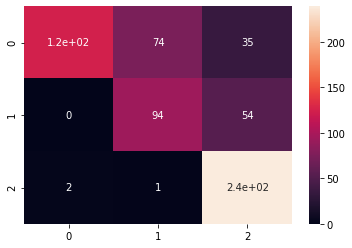

In [12]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
 layer.trainable = False
 
x = vgg.output
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)

prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=['accuracy'])

model_name = 'second_model.hdf5'
mcp_save = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
vgg_model, history = fit_model(model, mcp_save, model_name, 64, 20)
run_test(vgg_model)

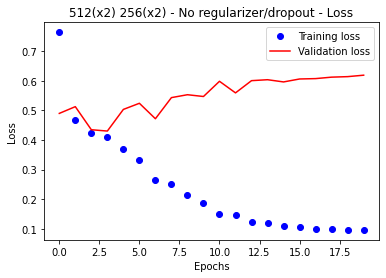

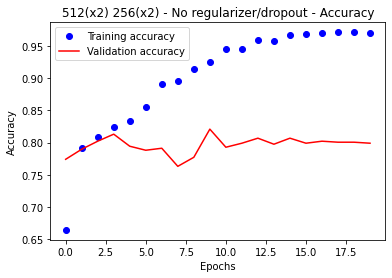

In [13]:
plot_loss_history(history, "512(x2) 256(x2) - No regularizer/dropout - Loss")
plot_loss_accuracy(history, "512(x2) 256(x2) - No regularizer/dropout - Accuracy")

## L2/Drop Batch size 64

Epoch 1/20
72/72 [==============================] - 23s 310ms/step - loss: 1.0617 - accuracy: 0.5687 - val_loss: 0.5323 - val_accuracy: 0.7601
Epoch 2/20
72/72 [==============================] - 23s 322ms/step - loss: 0.5540 - accuracy: 0.7527 - val_loss: 0.4767 - val_accuracy: 0.8069
Epoch 3/20
72/72 [==============================] - 22s 310ms/step - loss: 0.5190 - accuracy: 0.7749 - val_loss: 0.4812 - val_accuracy: 0.7819
Epoch 4/20
72/72 [==============================] - 22s 305ms/step - loss: 0.5343 - accuracy: 0.7639 - val_loss: 0.4507 - val_accuracy: 0.8084
Epoch 5/20
72/72 [==============================] - 22s 311ms/step - loss: 0.5062 - accuracy: 0.7771 - val_loss: 0.4415 - val_accuracy: 0.8193
Epoch 6/20
72/72 [==============================] - 23s 315ms/step - loss: 0.4352 - accuracy: 0.8103 - val_loss: 0.4583 - val_accuracy: 0.8100
Epoch 7/20
72/72 [==============================] - 22s 311ms/step - loss: 0.4509 - accuracy: 0.8052 - val_loss: 0.4872 - val_accuracy: 0.7477

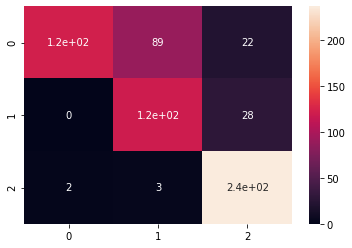

In [15]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
 layer.trainable = False
 
x = vgg.output
x = Flatten()(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)

prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.001),
                    metrics=['accuracy'])


model_name = 'second_model_l2_drop.hdf5'
mcp_save = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
vgg_model, history = fit_model(model, mcp_save, model_name, 64, 20)
run_test(vgg_model)

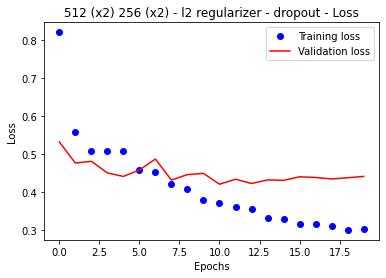

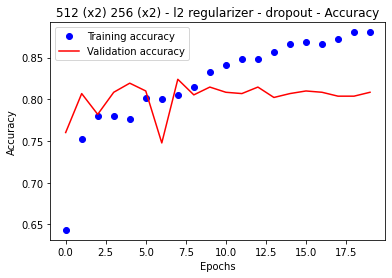

In [16]:
plot_loss_history(history, "512 (x2) 256 (x2) - l2 regularizer - dropout - Loss")
plot_loss_accuracy(history, "512 (x2) 256 (x2) - l2 regularizer - dropout - Accuracy")

## L2/Drop Batch size 128


Epoch 1/20
72/72 [==============================] - 23s 312ms/step - loss: 0.9618 - accuracy: 0.5430 - val_loss: 0.5537 - val_accuracy: 0.7274
Epoch 2/20
72/72 [==============================] - 23s 322ms/step - loss: 0.5734 - accuracy: 0.7273 - val_loss: 0.4845 - val_accuracy: 0.8037
Epoch 3/20
72/72 [==============================] - 22s 309ms/step - loss: 0.5221 - accuracy: 0.7733 - val_loss: 0.5298 - val_accuracy: 0.7991
Epoch 4/20
72/72 [==============================] - 22s 305ms/step - loss: 0.5036 - accuracy: 0.7892 - val_loss: 0.4684 - val_accuracy: 0.8100
Epoch 5/20
72/72 [==============================] - 22s 312ms/step - loss: 0.4774 - accuracy: 0.7890 - val_loss: 0.4439 - val_accuracy: 0.8037
Epoch 6/20
72/72 [==============================] - 23s 314ms/step - loss: 0.4363 - accuracy: 0.8063 - val_loss: 0.4227 - val_accuracy: 0.8193
Epoch 7/20
72/72 [==============================] - 22s 309ms/step - loss: 0.4192 - accuracy: 0.8250 - val_loss: 0.4537 - val_accuracy: 0.8162

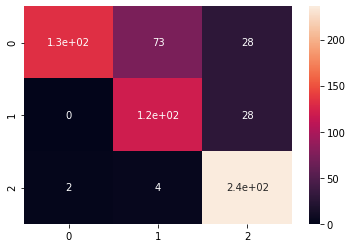

In [22]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
 layer.trainable = False
 
x = vgg.output
x = Flatten()(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.2)(x)

prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(lr=0.0005),
                    metrics=['accuracy'])


model_name = 'second_model_l2_drop_batch_128.hdf5'
mcp_save = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', mode='min')
vgg_model, history = fit_model(model, mcp_save, model_name, 128, 20)
run_test(vgg_model)

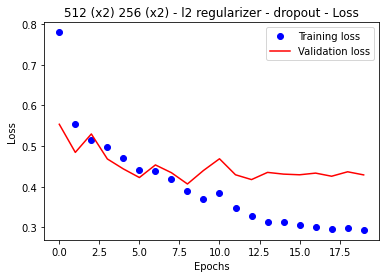

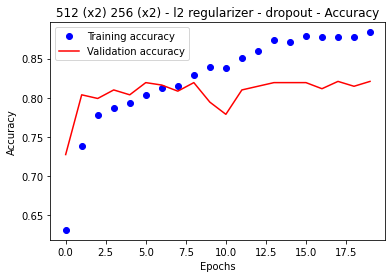

In [23]:
plot_loss_history(history, "512 (x2) 256 (x2) - l2 regularizer - dropout - Loss")
plot_loss_accuracy(history, "512 (x2) 256 (x2) - l2 regularizer - dropout - Accuracy")